In [1]:
import gym
import env
from autograd import grad, jacobian
import autograd.numpy as np
from matplotlib import pyplot as plt
from IPython import display
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [2]:
# Learns set of locally linear Gaussian models (y = Ax + Bu) by fitting joint gmm with n_components and conditioning
class learn_model:
    
    def __init__(self,state_dim,control_dim,n_components=10):
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.n_components = n_components
        
        self.A = [np.eye(state_dim) for i in range(n_components)]
        self.B = [np.zeros((state_dim,control_dim)) for i in range(n_components)]
        self.Sigma = [np.eye(state_dim) for i in range(n_components)]
        self.idx = 0
        self.model_trained = False
    
    # Retrain model using set of sequential states and corresponding controls
    def update_model(self,x,u):
        
        state_action_pairs = np.hstack((np.array(x)[1:],np.array(u)[1:],np.array(x)[0:-1]))
        
        d = self.state_dim
        
        gmm = GaussianMixture(n_components=self.n_components).fit(state_action_pairs)
        
        probs = []
        
        for k in range(gmm.n_components):
            cov_aa = gmm.covariances_[k,0:d,0:d]
            cov_ab = gmm.covariances_[k,0:d,d:]
            cov_ba = gmm.covariances_[k,d:,0:d]
            cov_bb = gmm.covariances_[k,d:,d:]

            M = cov_ab[:,:].dot(np.linalg.inv(cov_bb[:,:]))

            self.A[k] = M[:,-d:]
            self.B[k] = M[:,0:-d]

            self.Sigma[k] = cov_aa[:,:] - (M.dot(cov_bb[:,:])).dot(M.T)
            
        self.idx = gmm.predict(state_action_pairs[-1,:].reshape(1,-1))[0]
        self.gmm = gmm
        self.model_trained = True
    
    # Get linear model most probable given current state, control and previous state
    def update_idx(self,xt,ut,xt_1):
        if self.model_trained:
            self.idx = self.gmm.predict(np.hstack((xt.ravel(),ut.ravel(),xt_1.ravel())).reshape(1,-1))[0]
        else:
            self.idx = 0
        return self.idx
        
    # Dynamic model given current model index
    def dynamics(self,x,u):
        
        A = self.A[self.idx]
        B = self.B[self.idx]
        
        return np.matmul(A,x) + np.matmul(B,u)

In [3]:
# Iterative linear quadratic regulator using model learner
class ILqr:
    
    def __init__(self, running_cost, final_cost, state_dim, control_dim, horizon=10,n_components=10):
        
        self.v = [0.0 for _ in range(horizon+1)]
        self.v_x = [np.zeros(state_dim) for _ in range(horizon+1)]
        self.v_xx = [np.zeros((state_dim,state_dim)) for _ in range(horizon+1)]
        
        self.l = running_cost
        self.lf = final_cost
        
        self.model_learner = learn_model(state_dim,control_dim,n_components)
        self.horizon = horizon
        
    # Update autograd jacobians using current dynamics estimate
    def update_jacobians(self,xt,ut,xt_1):
        
        # get current linear model
        self.model_learner.update_idx(xt,ut,xt_1)
        
        # Recompute Jacobians
        self.f_x = jacobian(self.model_learner.dynamics,0)
        self.f_u = jacobian(self.model_learner.dynamics,1)
        
        self.f_xx = jacobian(self.f_x, 0)
        self.f_uu = jacobian(self.f_u, 1)
        self.f_ux = jacobian(self.f_u, 0)
        
        self.lf_x = grad(self.lf,0)
        self.lf_xx = jacobian(self.lf_x,0)
        
        self.l_x = grad(self.l,0)
        self.l_u = grad(self.l,1)
        
        self.l_xx = jacobian(self.l_x,0)
        self.l_uu = jacobian(self.l_u,1)
        self.l_ux = jacobian(self.l_u,0)
    
    # ILQR backward pass
    def backward(self, x_seq, u_seq):
        
        self.update_jacobians(x_seq[-1],u_seq[-1],x_seq[-2])
        
        self.v[-1] = self.lf(x_seq[-1],u_seq[-1])
        self.v_x[-1] = self.lf_x(x_seq[-1],u_seq[-1])
        self.v_xx[-1] = self.lf_xx(x_seq[-1],u_seq[-1])
        
        k_seq = []
        kk_seq = []
        
        for t in range(self.horizon-1,-1,-1):
            
            x = x_seq[t]
            u = u_seq[t]
            
            self.update_jacobians(x_seq[t],u_seq[t],x_seq[t-1])
            
            # Evaluate expansion coefficients
            f_x_t = self.f_x(x,u)
            f_u_t = self.f_u(x,u)
            
            f_xx_t = self.f_xx(x,u)
            f_uu_t = self.f_uu(x,u)
            f_ux_t = self.f_ux(x,u)
            
            l_x_t = self.l_x(x,u)
            l_u_t = self.l_u(x,u)
            
            l_xx_t = self.l_xx(x,u)
            l_uu_t = self.l_uu(x,u)
            l_ux_t = self.l_ux(x,u)
            
            v_x_t = self.v_x[t+1]
            v_xx_t = self.v_xx[t+1]
            
            q_x = l_x_t + np.matmul(f_x_t.T,v_x_t)
            q_u = l_u_t + np.matmul(f_u_t.T,v_x_t)
            
            q_xx = l_xx_t + np.matmul(np.matmul(f_x_t.T,v_xx_t),f_x_t) + (v_x_t.reshape(-1,1,1)*f_xx_t).sum(axis=0)
            
            q_uu = l_uu_t + np.matmul(np.matmul(f_u_t.T,v_xx_t),f_u_t) + (v_x_t.reshape(-1,1,1)*f_uu_t).sum(axis=0)
            
            q_ux = l_ux_t + ((f_u_t.T).dot(v_xx_t)).dot(f_x_t) + (v_x_t.reshape(-1,1,1)*f_ux_t).sum(axis=0)
        
            # Invert with some regularisation
            q_uu_inv = np.linalg.inv(q_uu.reshape(1,1)+1e-9*np.eye(q_uu.shape[0]))
            
            k = -q_uu_inv.dot(q_u) # open loop gain
            kk = -q_uu_inv.dot(q_ux) # feedback gain
            
            
            self.v[t] += 0.5*(k.T.dot(q_uu)).dot(k) + k.T.dot(q_u)#q_u.dot(k)
            self.v_x[t] = q_x + (kk.T.dot(q_uu)).dot(k) + kk.T.dot(q_u) + q_ux.T.dot(k)#q_u.dot(kk)
            self.v_xx[t] = q_xx + (kk.T.dot(q_uu)).dot(kk) + kk.T.dot(q_ux) + q_ux.T.dot(kk)#q_ux.T.dot(kk)
            
            k_seq.append(k)
            kk_seq.append(kk)
        
        k_seq.reverse()
        kk_seq.reverse()
        
        return k_seq,kk_seq
    
    # ILQR Forward pass
    def forward(self, x_seq, u_seq, k_seq, kk_seq, alpha):
        
        x_seq_hat = np.array(x_seq)
        u_seq_hat = np.array(u_seq)
        
        for t in range(len(u_seq)):
            control = alpha**t*k_seq[t] + np.matmul(kk_seq[t], (x_seq_hat[t] - x_seq[t]))
            u_seq_hat[t] = np.clip(u_seq[t] + control,-2,2)
            x_seq_hat[t+1] = self.model_learner.dynamics(x_seq_hat[t], u_seq_hat[t])
            self.model_learner.update_idx(x_seq_hat[t+1],u_seq_hat[t],x_seq_hat[t])
            
        return x_seq_hat, u_seq_hat

In [4]:
# Pendulum cost function
def cost(x,u):
    costs = angle_normalize(x[0])**2 + .1*x[1]**2 + .001*(u**2)
    return costs

In [5]:
# Helper to wrap angles
def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

In [6]:
def get_state_from_gym(state):
    th = np.arctan2(state[1],state[0])
    if (th >= 0):
        th = th - 2*np.pi
    return np.array((th,state[2]))

In [7]:
# Create model learning ilqr - as in Guided Policy Search
# Use a short time horizon, as local linear models only correct for brief time
ilqr = ILqr(cost, cost, state_dim=2, control_dim=1, n_components=10, horizon=10)

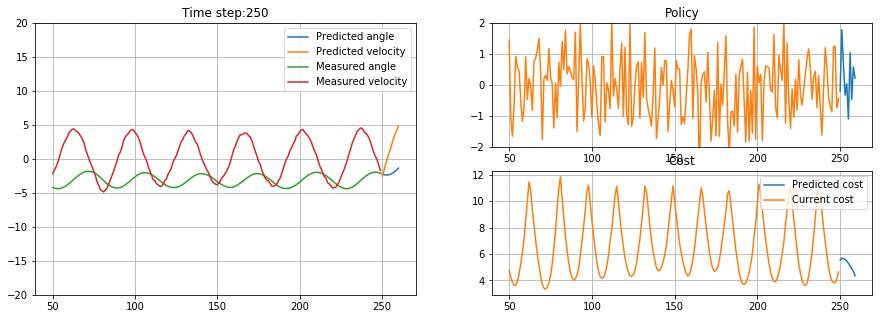

In [ ]:
from IPython import display

env = gym.make("Pendulum-v0")
env.reset()

Nbabble = 400

# Get start state
gym_state,_,_,_ = env.step([0])
state = get_state_from_gym(gym_state)

# Initial, random control trajectory
u_seq = [np.random.randn(1,) for _ in range(ilqr.horizon)]

# Lists 
c_seq = []

# List of states and actions for model fitting
state_list = []
control_list = []

plt.figure(figsize=(15,5))
for j in range(2000):
    
    state_list.append(state)
    control_list.append(u_seq[0])
    
    x_seq = [state]
    c_seq.append(cost(x_seq[0],u_seq[0]))

    # Roll-out using current dynamics model and planned control sequence
    for t in range(ilqr.horizon):
        x_seq.append(ilqr.model_learner.dynamics(x_seq[-1], u_seq[t]))
        ilqr.model_learner.update_idx(x_seq[-1],u_seq[t],x_seq[-2])

    if (len(state_list) > Nbabble):
        # ILQR Control under current model
        if ilqr.model_learner.model_trained:
            for rep in range(3):
                k_seq, kk_seq = ilqr.backward(x_seq, u_seq)
                x_seq, u_seq = ilqr.forward(x_seq, u_seq, k_seq, kk_seq,alpha=0.99)
    else:
        # Motor babble for aNbabble samples to learn
        u_seq = [np.random.randn(1,) for _ in range(ilqr.horizon)]
    
    # Execute control
    env.render()
    gym_state,_,_,_ = env.step(u_seq[0])
    state = get_state_from_gym(gym_state)
         
    # Update dynamics models
    if (((j%10) == 0)&(len(state_list) > ilqr.model_learner.n_components)):
        ilqr.model_learner.update_model(np.array(state_list),np.array(control_list))
    
    plt.cla()
    plt.subplot(1,2,1)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon+1),x_seq)
    plt.plot(np.arange(max(j-200,0),j),np.array(state_list)[max(j-200,0):j,0],label='Angle history')
    plt.plot(np.arange(max(j-200,0),j),np.array(state_list)[max(j-200,0):j,1],label='Velocity history')
    plt.legend(['Predicted angle','Predicted velocity','Measured angle', 'Measured velocity'])
    plt.ylim(-20,20)
    plt.grid()
    plt.title('Time step:%d'%j)

    plt.subplot(2,2,2)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon),u_seq)
    plt.plot(np.arange(max(j-200,0),j),control_list[max(j-200,0):j])
    plt.title('Policy')
    plt.ylim(-2,2)
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon),[cost(x_seq[t],u_seq[t]) for t in range(ilqr.horizon)],label='Predicted cost')
    plt.plot(np.arange(max(j-200,0),j),c_seq[max(j-200,0):j],label='Current cost')
    plt.title('Cost')
    plt.legend()
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())
        
env.close()